<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Tuning K-Means and Cluster Evaluation Metrics

_Authors: Dave Yerrington (SF), Joseph Nelson (DC)_

---

![](http://scikit-learn.org/stable//_images/sphx_glr_plot_kmeans_silhouette_analysis_003.png)

### Learning Objectives
*After this lesson, you will be able to:*
- Evaluate the results of a K-Means Clustering Analysis
- Understand inertia and how K-Means is fit
- See visually why inertia can lead to poor clusters
- Understand the importance of visually evaluating clusters
- Learn how to compute cohesion, separation, and the silhouette coefficient
- Interpret the silhouette coefficient
- Visualize the silhouette across different numbers of clusters
- Learn how to use the elbow method with inertia to choose K
- Try out alternative evaluation metrics that are only available when true labels exist 


### Lesson Guide
- [Review: K-Means](#review)
- [Introduction: problems with K-Means](#intro)
- [Fitting K-Means: Inertia](#inertia)
- [Evaluating clusters](#evaluating)
- [Visual evaluation of clusters](#visual)
- [The silhouette score/coefficient](#sil)
    - [Cohesion](#cohesion)
    - [Separation](#separation)
    - [Silhouette coefficient](#sil-coef)
- [Interpreting the silhouette coefficient](#interpret-sil)
- [Using the silhouette coefficient to choose the optimal K](#optimal-k)
- [Explore the silhouette score with chemical composition data](#chem)
    - [Sklearn silhouette plotting function](#sklearn-plot)
    - [Inertia vs. K clusters: the elbow method](#inertia-plot)
- [Evaluating clusters when the ground truth is available](#ground)
    - [Completeness score](#completeness)
    - [Homogeneity](#homo)
    - [V measure score](#v-measure)
    - [Mutual information score](#mutual)
- [Additional resources](#resources)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

<a id='review'></a>
## Review: K-Means clustering
---

### How do we use K-Means end-to-end?
- Discuss how we would use this step-by-step.

### What are some problems with K-Means?
- Discuss some of the shortcomings of K-Means.
- How might we think about "good" clusters vs. "bad" clusters?

<a id='intro'></a>
## Introduction: problems with K-Means

---

There are many problems with K-Means. One of the biggest is that it's possible to get widely different results based on initialization. Other problems include:
- Different solutions can converge with random initialization
- Not everything can be reflected as a "glob" of points
   - Irregular shapes
   - Different densities
   - Inconsistent cluster spacing
- Interpretation of results dificult without subject matter expertise
   - Accuracy is highly subjective
   - No formula for the correct number of clusters

![](http://www.aishack.in/static/img/tut/kmeans-bad-initial-guess.jpg)

<a id='inertia'></a>

## Fitting K-Means: Inertia

---

The K-Means fitting procedure is based on "Inertia", or the within-cluster sum of squares criterion. Inertia can be recognized as a measure of internal coherence.

### $$ \text{Inertia } = \sum_{i=1}^n \underset{\mu_i \in C}{min}(||x_j - \mu_i||^2) $$

Where $C$ denotes the set of clusters.

**Drawbacks:**
- Fitting using Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.
- Inertia is not a *normalized* metric: we just know that lower values are better and zero is optimal. In very high-dimensional spaces, Euclidean distances tend to become inflated (this is one instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as PCA prior to k-means clustering can alleviate this problem and speed up the computations.

![inertia2](./assets/inertia2.png)

<a id='evaluating'></a>
## Evaluating clusters

---

The best evaluation of your clustering algorithm is the visual inspection of the clusters. However, it is rare that we have a dataset with few enough features that visual inspection is reasonable. We need to be able to compute metrics that measure how good given clusters fit the structure of your data.

If we were to make some basic assumptions about cluster quality, they would be:

- High intra-class similarity (within clusters)
- Low inter-class similarity (betwee clusters)


<a name="visual"></a>
## Visual evaluation of clusters

---

When evaluating clusters, the best and easiest method when the data allows is to visually examine the output of the clustering algorithm. After we run the algorithm and calculate the centroids we can plot the clusters to see where the centroids are located and how well the clusters group the data. 

![](http://simplystatistics.org/wp-content/uploads/2014/02/kmeans.gif)

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs

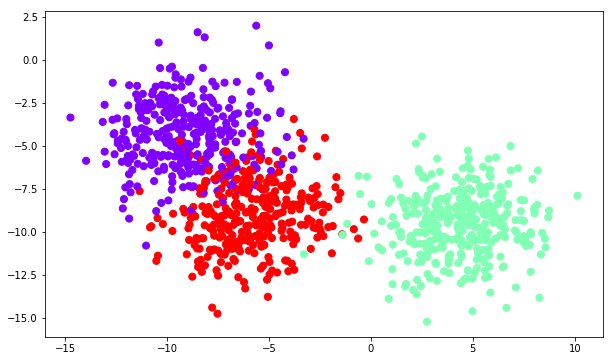

In [3]:
# Make some clusters
X, y = make_blobs(n_samples=1000,
                  n_features=2,
                  centers=3,
                  cluster_std=2,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=21)

fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

In [4]:
# Run k-means
k = 3
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

In [5]:
# Fix permuted labels
from scipy import stats
labels = np.zeros_like(clusters)
for i in range(4):
    mask = (clusters == i)
    labels[mask] = stats.mode(y[mask])[0]

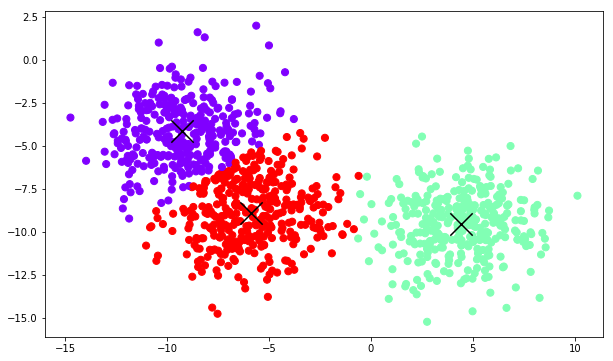

In [6]:
#Plot our centroids
fig, ax = plt.subplots(figsize=(10,6))

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='rainbow');

plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=500, linewidths=5,
            color='k', zorder=10);

<a id='sil'></a>
## The silhouette score/coefficient 

---

The silhouette coefficient evaluates the validity of your model's clusters based on the ideas of **cohesion** and **separation**. 

<a id='cohesion'></a>
### Cohesion

Cohesion measures clustering effectiveness within a cluster. It is calculated:

### $$ \hat{C}(C_i) = \underset{x \in C_i}{\sum} d(x, c_i) $$

Where $C_i$ is the $i$th cluster, $c_i$ is the $i$th centroid, $d$ is the distance metric, and $x$ is the observation.

<a id='separation'></a>
### Separation

Separation measures clustering effectiveness *between* clusters. It is calculated:

### $$\hat{S}(C_i, C_j) = d(c_i, c_j) $$

Where $C_i$ and $C_j$ are clusters, $d$ is the distance metric, and $c_i$ and $c_j$ are the clusters' centroids.


![](https://snag.gy/FLwIql.jpg)

<a id='sil-coef'></a>

### Silhouette coefficient

The silhouette coefficient combines the cohesion and the separation into a single metric. The silhouette coefficient for a single observation $i$ is calculated:

### $$ SC_i = \frac{b_i - a_i}{max(a_i, b_i)} $$

such that:
- $a_i$ = mean intra-cluster distance of the sample to others within the cluster.
- $b_i$ = the mean nearest-cluster distance from the sample to those within the nearest non-assigned cluster.

**The coefficient ranges from -1 to 1:**
- A score of 1 indicates the maximum cohesion and separation of clusters.
- A score of -1 indicates the minimum cohesion and separation of clusters.

![](https://snag.gy/3eCGRi.jpg)

<a id='interpret-sil'></a>
## Interpreting the silhouette coefficient
---

When you calculate the silhouette score using sklearn you get out a single number. THis is the average silhouette score for all of the individual observations.

In general, we want separation to be high and cohesion to be low. This corresponds to a value of **SC** close to +1.

A negative silhouette coefficient means the cluster radius is larger than the space between clusters, and thus clusters overlap. Another way to think about this is that negative values indicate that non-assigned clusters are more similar than the assigned cluster.


<a id='optimal-k'></a>
## Using the silhouette coefficient to choose the optimal K

---

We can use the silhouette coefficient to determine an optimal K.  **It is important to keep in mind that this is still a subjective measure and not an official measure of quality.  It can help you but it's no substitute for knowing your data**.  

Visually inspecting your data and evaluating how the silhouette changes across numbers of clusters can give you a rough sense of the quality for K clusters in terms in cohesion and seperation.

<a id='chem'></a>
## Explore the silhouette score with chemical composition data
---

Let's load in a dataset on chemical composition and plot the silhouette scores for different numbers of clusters.

In [7]:
import seaborn as sns

csv_file = "https://vincentarelbundock.github.io/Rdatasets/csv/cluster/chorSub.csv"
df = pd.read_csv(csv_file).iloc[:, 1:]

In [8]:
df.head()

,Al,Ca,Fe,K,Mg,Mn,Na,P,Si,Ti
0,101,11,-22,-17,-34,-41,27,-36,-58,-28
1,50,129,23,-82,47,33,61,90,-24,9
2,5,65,-22,-96,-33,7,47,49,30,-39
3,-40,-16,-158,-70,-104,-114,53,-61,103,-160
4,-13,30,-82,-113,26,-41,65,-90,43,-130


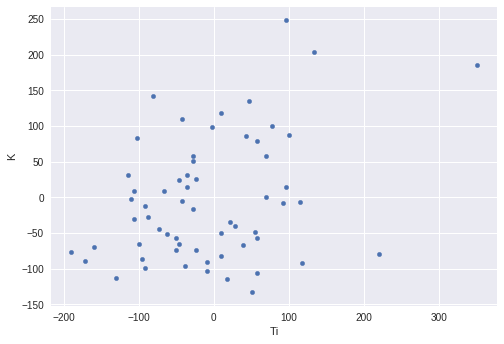

In [9]:
df.plot(kind="scatter", x="Ti", y="K")

<a id='sklearn-plot'></a>
### Sklearn silhouette plotting function

Below is some code taken from the sklearn website that helps visualize the silhouette score across different numbers of clusters.

The vertical line indicates the average silhouette score across all observations. The individual scores are plotted in sorted, colored sections for each cluster.

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.41813365052


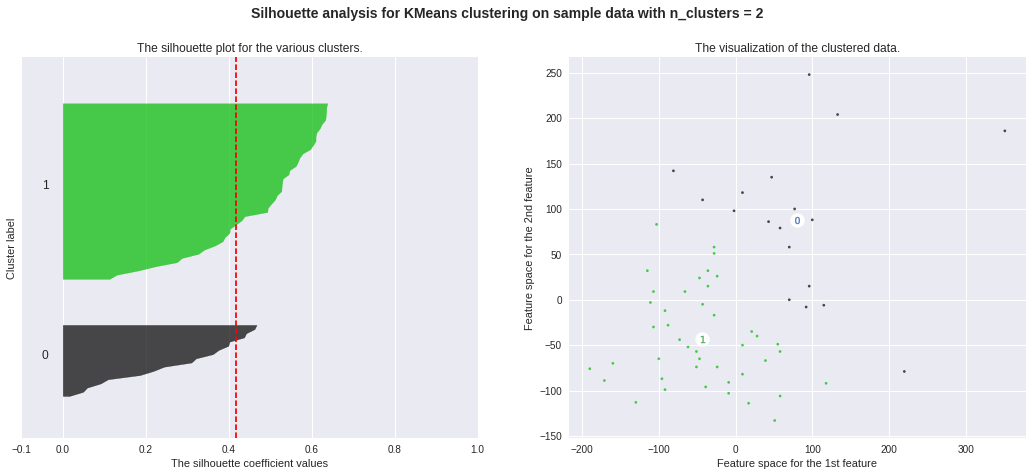

For n_clusters = 3 The average silhouette_score is : 0.388746564019


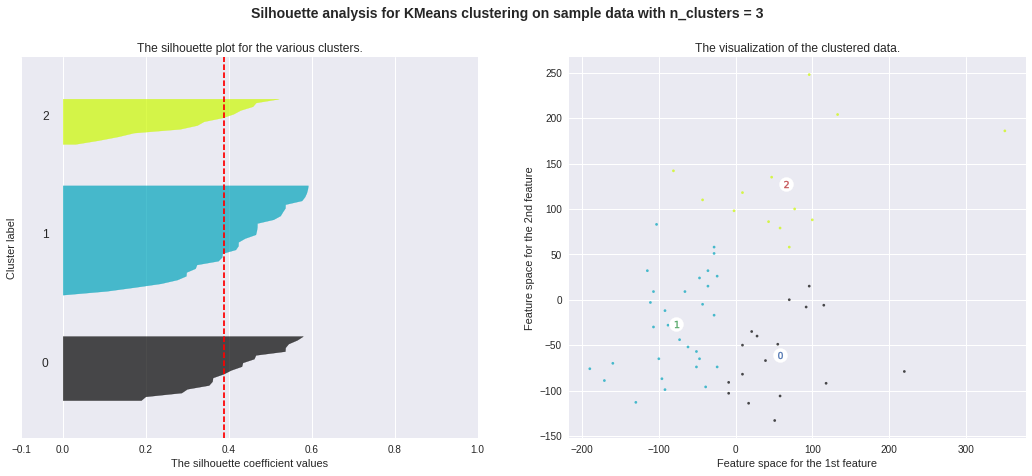

For n_clusters = 4 The average silhouette_score is : 0.388852985051


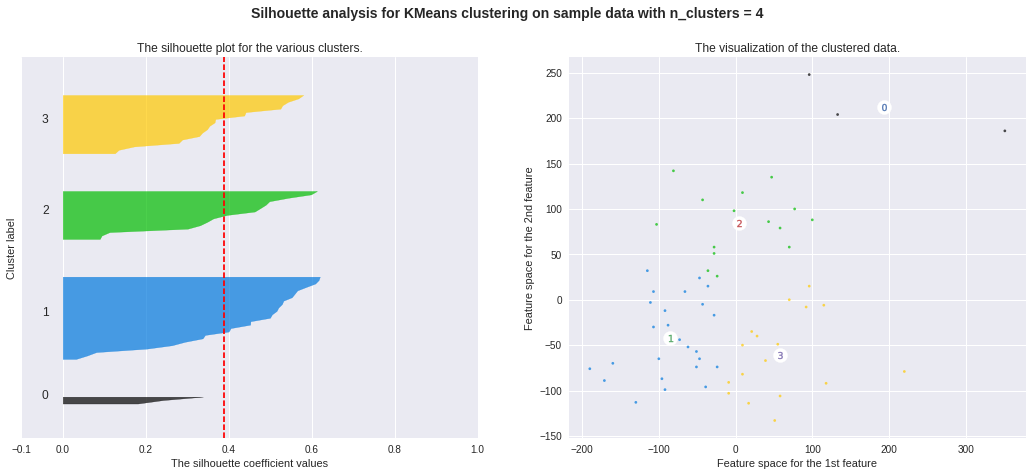

For n_clusters = 5 The average silhouette_score is : 0.370095149106


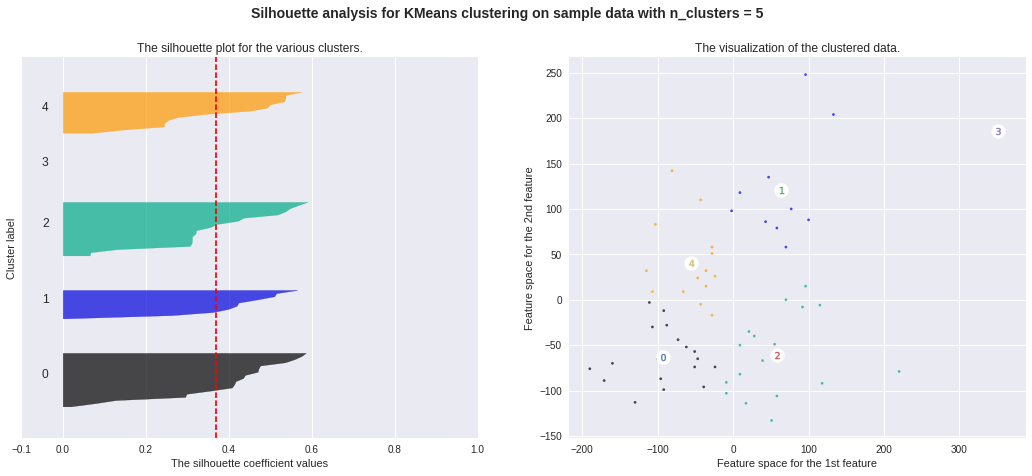

For n_clusters = 6 The average silhouette_score is : 0.36958221899


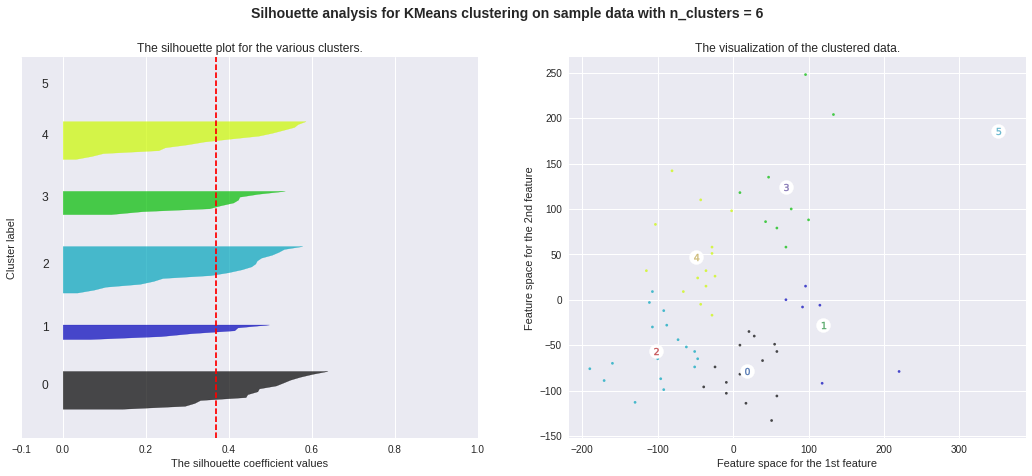

In [10]:
from __future__ import print_function

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)


X = df[['Ti', 'K']].values
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

<a id='inertia-plot'></a>
### Inertia vs. K clusters: the elbow method

You can plot the inertia vs. the K number of clusters to get an idea of what the optimal number of clusters would be for the dataset. The "elbow" technique, though controversial, is a great heuristic to evaluate the optimal K.  Basically, we look for the K where the inertia has an "elbow": the point where decreases in inertia are considerably more marginal than for previous increases in K.

>"More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified." [Elbow Method](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method)

An elbow plot may look something like this:

![](http://i.stack.imgur.com/BzwBY.png)

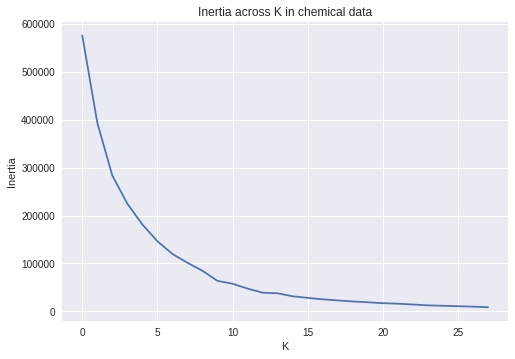

In [11]:
# As you can see, sometimes there is not a well-defined elbow!
inertias = []
for n_clusters in range(2,30):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    inertia = kmeans.inertia_
    inertias.append(inertia.mean())

plt.plot(inertias)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.title("Inertia across K in chemical data")
sns.despine()

<a id='ground'></a>

## Evaluating clusters when the ground truth is available

---

The silhouette score is a particularly useful metric in that it does not require us to have the true labels for the clusters (which is most often the case if we need to do clustering to begin with!).

When the true labels are available, there are other methods we can use to evaluate the performance of our clustering algorithm and choice of K.
- Completeness Score 
- Homogeneity 
- V Measure Score 
- Mutual Information Score

**Load the wine dataset and pull out red vs. white as the true clusters.**

In [12]:
wine = pd.read_csv('./datasets/winequality_merged.csv')
wine.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1


In [13]:
true = wine.red_wine.values

**Select the other variables to use for clustering.**

In [14]:
from sklearn.preprocessing import StandardScaler

X = wine.iloc[:, :-1]
Xs = StandardScaler().fit_transform(X)

**Fit a KMeans model with K=2 and extract the predicted labels.**

In [15]:
k_wine = KMeans(n_clusters=2)
k_wine.fit(Xs)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [16]:
predicted = k_wine.labels_

<a id='completeness'></a>
### Completeness score

**Completeness indicates that all members of a given class are assigned to the same cluster.**
- A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster. (If a cluster contains all of the data points of a single class.) 
- Score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.

You can calculate completeness score using sklearn with:
```python
from sklearn.metrics import completeness_score
print completeness_score(true_clusters, predicted_clusters)
```


In [17]:
from sklearn.metrics import completeness_score
completeness_score(true, predicted)

0.83963866419037747

<a id='homo'></a>

### Homogeneity

**Homogeneity indicates each cluster contains only members of a single class.**
- A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class. (Every cluster is composed of data points from only 1 class.  Essentually there are representative of a class)
- score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling

You can calculate the homogeneity using sklearn:
```python
from sklearn.metrics import homogeneity_score
print homogeneity_score(true_clusters, predicted_clusters)
```


In [18]:
from sklearn.metrics import homogeneity_score
homogeneity_score(true, predicted)

0.85707435838457957

<a id='v-measure'></a>

## V measure score

The V measure score is a combination of the homogeneity and completeness metrics:

### $$ V = \frac{2 \cdot \text{homogeneity} \cdot \text{completeness}}{\text{homogeneity} + \text{completeness}} $$

In sklearn:
```python
from sklearn.metrics import v_measure_score
print v_measure_score(true_clusters, predicted_clusters)
```


In [19]:
from sklearn.metrics import v_measure_score
v_measure_score(true, predicted)

0.84826692529739389

<a id='mutual'></a>

### Mutual information score

**Mutual information measures the agreement between two assignments (clusters, in this case).**
- There are various mutual information scores in Sklearn. Be wary of the basic `mutual_info_score` as the output does not have a normal scale, thus making it much harder to judge.

### $$ MI(i,j) = \sum_{a,b} P(a_i, b_j) \cdot log\left(\frac{P(a_i, b_j)}{P(a_i) \cdot P(b_j)}\right) $$

Where:

$MI(i,j)$ is the mutual information of assignment $i$ and $j$, which can be predicted vs. true.

$P(a_i, a_j)$ is the probability that observation $a$ in group $i$ is the same as observation $b$ in group $j$. In other words, the probability that the predicted and true are the same.

$P(a_i)$ is the probability of observation $a$ in group $i$, and $P(b_i)$ is the probability of observation $b$ in group $j$.

The unnormalized mutual information score can be calculated in sklearn with:
```python
from sklearn.metrics import mutual_info_score
mutual_info_score(true_clusters, predicted_clusters)
```

That is not guaranteed to be between 0. and 1. For the normalized version that is, use the adjusted scorer:
```python
from sklearn.metrics import adjusted_mutual_info_score
adjusted_mutual_info_score(true_clusters, predicted_clusters)
```

**Adjusted mutual information:**

### $$ AMI(U, V) = \frac{MI(U, V) - E(MI(U, V))}{max(H(U), H(V)) - E(MI(U, V))} $$

Adjusted accounts for chance or variance.  A Standard MI Score tends to favor comparing cluster labels when there are a large amount of clusters.  This is nulled when using AMI.

AMI is also on a normalized scale of 0 to 1.0 as well.

In [20]:
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score

print(mutual_info_score(true, predicted))
print(adjusted_mutual_info_score(true, predicted))

0.478268978483
0.839616984987


<a id='resources'></a>
## Additional resources

---

- [Davies Bouldin Index (DBI)](https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index) _- The Davies-Bouldin index is the sum of the worst intra-to-inter cluster distance ratios over all kk clusters_
- [Dunn index](https://en.wikipedia.org/wiki/Dunn_index) _- Ratio between the smallest distance between observations not in the same cluster to the largest intra-cluster distance_
- [Clustering Countries Real GDP Growth](http://www.turingfinance.com/clustering-countries-real-gdp-growth-part2/)
- [SKLearn Clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [SKLearn K-Means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
- [SKLearn Silhouette Score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)